In [2]:
# https://metadata.geoportaal.ee/geonetwork/srv/eng/catalog.search#/home
# https://metadata.geoportaal.ee/geonetwork/srv/eng/catalog.search#/metadata/siseministeerium_knr

gn = "https://inspire.geoportaal.ee/geoserver/GN_kohanimed/wfs"

In [1]:
# https://geopython.github.io/OWSLib/usage.html#wfs

from owslib.wfs import WebFeatureService

In [4]:
wfs11 = WebFeatureService(url=gn, version='1.1.0')

wfs11.identification.title

'INSPIRE (GN) - Eesti kohanimeregistri kohanimed (WFS)'

In [5]:
import geopandas as gpd
from shapely.geometry import box

# <ows:LowerCorner>21.41493918814871 57.47561599021964</ows:LowerCorner>
# <ows:UpperCorner>28.256035600482093 59.83916717456523</ows:UpperCorner>

wgs84_bbox = box(21.41493918814871, 57.47561599021964, 28.256035600482093, 59.83916717456523)

eestbox = gpd.GeoDataFrame({ 'geometry': [wgs84_bbox]}, geometry="geometry", crs=4326)

In [6]:
import folium

m = folium.Map(location=[58.37, 26.72], tiles='Cartodb Positron', zoom_start=9, control_scale=True)
folium.GeoJson(eestbox.__geo_interface__, name="geojson").add_to(m)
m

In [7]:
extent_84 = eestbox.total_bounds
eestbox_3301 = eestbox.to_crs(3301)
extent_3301 = eestbox_3301.total_bounds
eestbox_merc = eestbox.to_crs(3857)
extent_merc = eestbox_merc.total_bounds

In [8]:

print(extent_84)
print(extent_3301) 
print(extent_merc) 

[21.41493919 57.47561599 28.2560356  59.83916717]
[ 344925.46198349 6373317.31916477  755206.10061015 6641172.7849267 ]
[2383900.12579363 7857958.23864874 3145447.49488228 8364016.95345018]


In [9]:
import contextily as ctx
import xyzservices.providers as xyz

import matplotlib.pyplot as plt

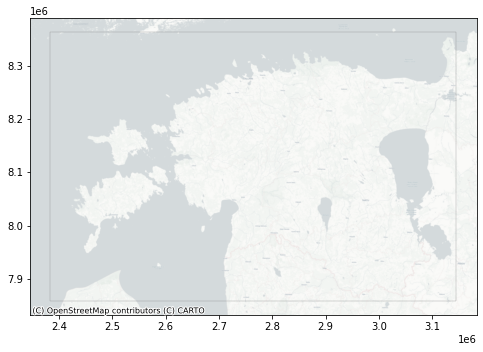

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
# ax.axis(extent_merc)
eestbox_merc.plot(ax=ax, facecolor="None", edgecolor="gray", lw=0.3)
ctx.add_basemap(ax, source=xyz.CartoDB.Positron)

In [11]:
[operation.name for operation in wfs11.operations]

['GetCapabilities', 'DescribeFeatureType', 'GetFeature', 'GetGmlObject']

In [12]:
list(wfs11.contents)

['GN_kohanimed:GN.GeographicalNames']

In [13]:
(minx, miny, maxx, maxy) = extent_84
(bottom, left, top, right) = extent_3301

# extent_84 [21.41493919 57.47561599 28.2560356  59.83916717]
# extent_3301 [ 344925.46198349 6373317.31916477  755206.10061015 6641172.7849267 ]
# extent_merc [2383900.12579363 7857958.23864874 3145447.49488228 8364016.95345018]

In [14]:
wfs11.get_schema('GN_kohanimed:GN.GeographicalNames')

{'properties': {'gml_id': 'string',
  'gml_metadataproperty_xlink_href': 'string',
  'gml_metadataproperty_xlink_title': 'string',
  'gml_original_coordinate_system': 'string',
  'gml_parent_property': 'string',
  'gml_description': 'string',
  'inspireid_identifier_localid': 'string',
  'inspireid_identifier_namespace': 'string',
  'beginlifespanversion': 'string',
  'name_geographicalname_language': 'string',
  'name_geographicalname_namestatus_xlink_href': 'string',
  'name_geographicalname_namestatus_xlink_title': 'string',
  'name_geographicalname_spelling_spellingofname_text': 'string',
  'type_xlink_href': 'string',
  'type_xlink_title': 'string',
  'name_geographicalname_grammaticalgender_xsi_nil': 'string',
  'xml_ns_uri': 'string',
  'name_geographicalname_nativeness_xsi_nil': 'string',
  'name_geographicalname_pronunciation_xsi_nil': 'string',
  'name_geographicalname_sourceofname_xsi_nil': 'string',
  'name_geographicalname_spelling_spellingofname_script_xsi_ni': 'string',


In [15]:
# xmlns:gml="http://www.opengis.net/gml"
# <gml:Point srsName="urn:x-ogc:def:crs:EPSG:4326"><gml:pos>57.8057 27.0209</gml:pos></gml:Point>

In [20]:
from owslib.etree import etree
import pandas as pd

def get_points(xml_tree):
    points = xml_tree.findall("//{http://www.opengis.net/gml}pos")

    for p in points:
        coord = [float(x) for x in p.text.split(" ")]
        if len(coord) == 2:
            yield coord


def partial_query(bbox, maxfeatures, startindex):

    # bbox = (bottom, left, top, right),
    response = wfs11.getfeature(typename='GN_kohanimed:GN.GeographicalNames',
                                bbox=bbox,
                                srsname='urn:x-ogc:def:crs:EPSG:4326', maxfeatures=maxfeatures, startindex=startindex)
    
    with open('data.gml', 'wb') as out:
        databytes = response.read()
        data = bytes(databytes)
        out.write( data)
        
    xml_tree = etree.parse('data.gml')
    return get_points(xml_tree)


In [21]:
list_target = 50000
returned = list_target
base_count = 0

collector = []

while returned >= list_target:
    print(f"start {base_count}")
    tmp_list = partial_query(bbox=(bottom, left, top, right), maxfeatures=list_target, startindex=base_count)
    ser1 = pd.Series(tmp_list)
    collector.append(ser1)
    returned = len(ser1)
    base_count = base_count + returned
    print(f"returned {returned} collected {len(collector)}")

start 0
returned 50000 collected 1
start 50000
returned 50000 collected 2
start 100000
returned 50000 collected 3
start 150000
returned 50000 collected 4
start 200000
returned 50000 collected 5
start 250000
returned 50000 collected 6
start 300000
returned 50000 collected 7
start 350000
returned 21237 collected 8


In [22]:
all_ser = pd.concat(collector)

In [23]:
all_ser.count()

371237

In [24]:
import os

if os.path.isfile("data.gml"):
    os.remove("data.gml")

In [74]:
from shapely.geometry import Point

tx = pd.DataFrame(all_ser.apply(lambda x: Point(x[1], x[0])))

tx = tx.rename(columns={0: "geometry"})

tg = gpd.GeoDataFrame(tx, geometry="geometry", crs=4326)
tg3 = tg.to_crs(3301)
tg3['x'] = tg3['geometry'].apply(lambda x: x.x)
tg3['y'] = tg3['geometry'].apply(lambda x: x.y)

In [118]:
# https://datashader.org/topics/index.html
# https://examples.pyviz.org/census/census.html

import matplotlib.pyplot as plt

import datashader as ds
import datashader.transfer_functions as tf

from functools import partial

from datashader.utils import export_image
from datashader.colors import colormap_select, Hot, viridis
from colorcet import fire

In [75]:
background = 'black'

# a "partially applied" convenience function for saving the image
export = partial(export_image, background = background, export_path=".")

# this "partially applied" convenience function handles colorizing of the image, incl reversing your colormap if you like
cm = partial(colormap_select, reverse=False)

In [76]:
x1, y1,x2, y2 = tg3.total_bounds
print(tg3.total_bounds)

[ 354965.72232906 6377428.52502377  738991.96699868 6633641.91335948]


In [123]:
x = x2 - x1
y = y2 - y1

print(f"{x} / {y}")

x_factor = x / y

print(x_factor)

w = 800 *2
h = int(w / x_factor)

print(h)

# for cover thumb
w_small = 480
h_small = int(w_small / x_factor)
print(h_small)

384026.24466962734 / 256213.38833570573
1.4988531519143478
1067
320


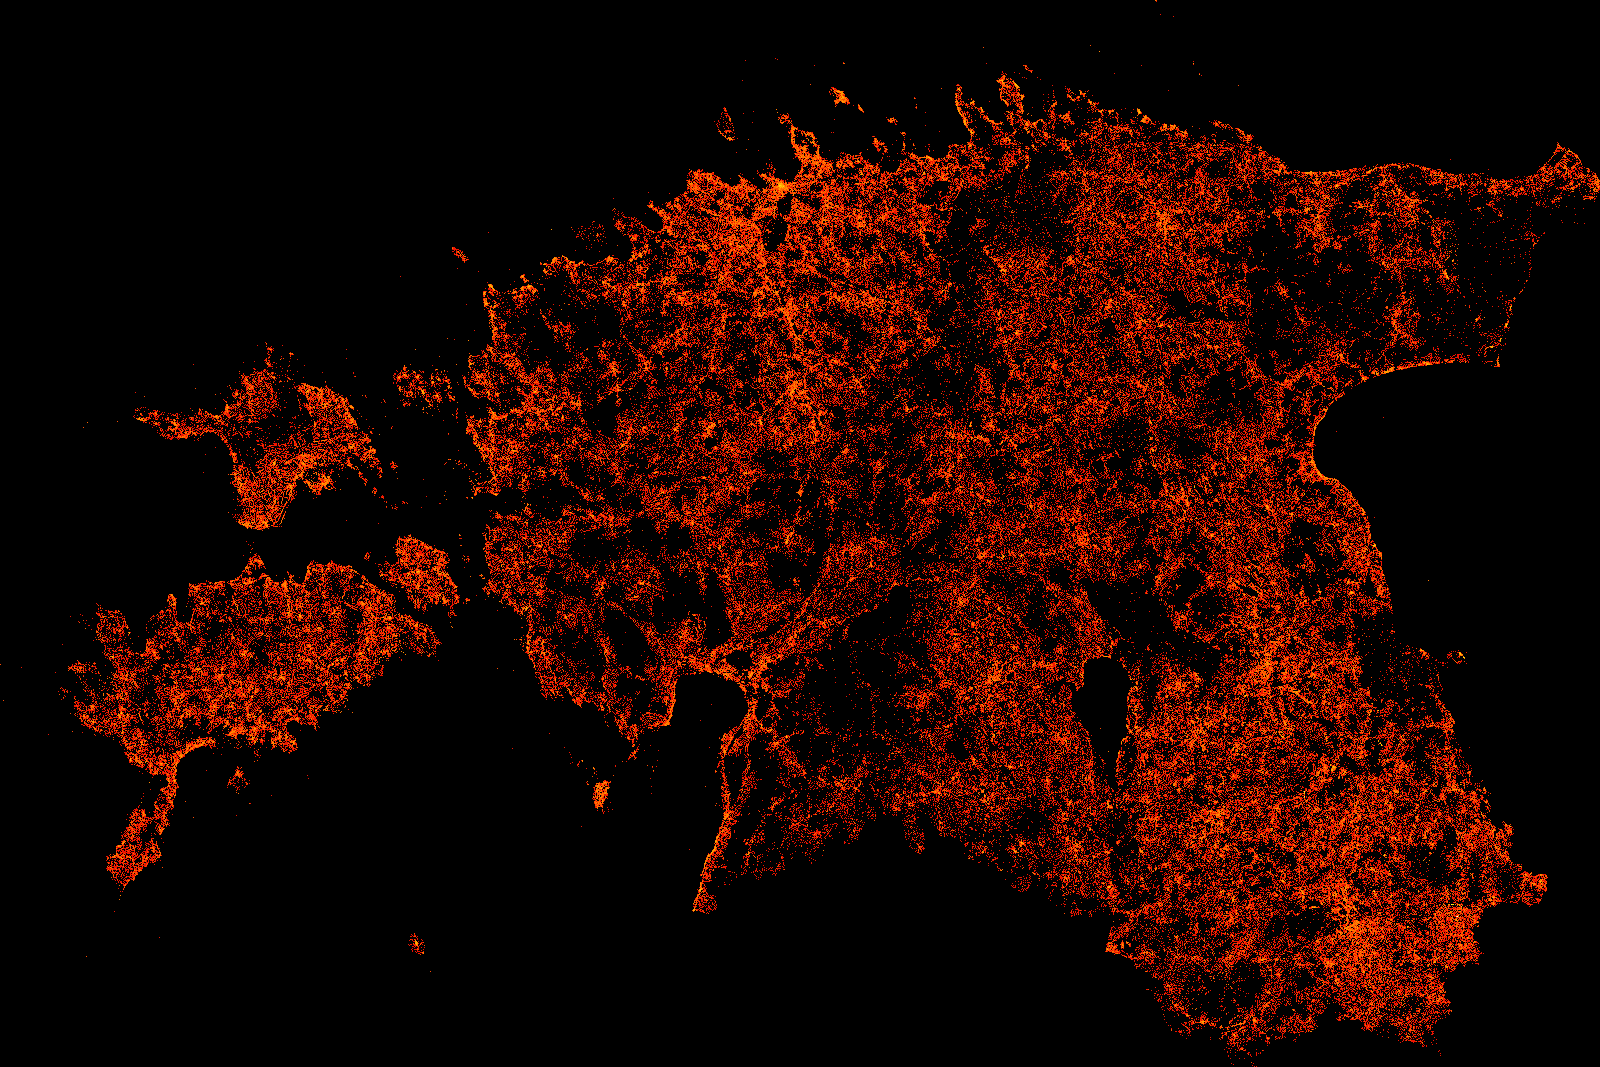

In [126]:
cvs = ds.Canvas(plot_width=w, plot_height=h)

agg = cvs.points(tg3, 'x', 'y') # , ds.count()

# to change color map you culd could use the parameter cmap=cm(viridis) or cmap=cm(Hot)
shaded = tf.shade(agg, cmap=cm(fire,0.5), how='log')

# img_dyn = tf.spread(shaded, px=1, how='add')

img = tf.set_background(shaded, background)

export(img,'../day_01')

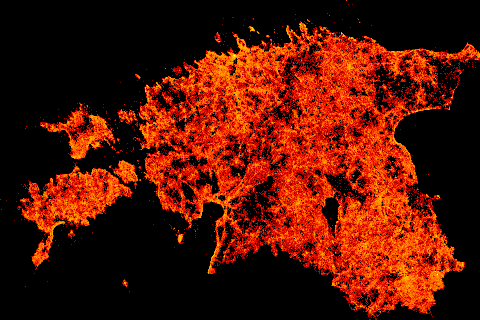

In [129]:
cvs = ds.Canvas(plot_width=w_small, plot_height=h_small)

agg = cvs.points(tg3, 'x', 'y') # , ds.count()

# to change color map you culd could use the parameter cmap=cm(viridis) or cmap=cm(Hot)
shaded = tf.shade(agg, cmap=cm(fire,0.3), how='log')

img = tf.set_background(shaded, background)

export(img,'../day_01_cover')